In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

Using Theano backend.


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
feats_import = pd.read_csv('Full_Data_2006_2016.csv')
try:
    feats_import = feats_import.drop(['Unnamed: 0'], axis=1)
    print "Reshape successful"
except:
    print "Successful import"
feats_import.head()

Reshape successful


,Season,Gameday,GoalsH,CornersH,ChancesH,GoalsA,CornersA,ChancesA,Attendance,TID_H,...,AY,HR,AR,HGA,AGA,FTGD,HTGD,Odds,HP3,AP3
0,2006.0,1.0,0.0,5.0,4.0,3.0,6.0,6.0,0.690265,6,...,2.0,0.0,0.0,0.309091,0.727273,-3.0,-2.0,0.656250,0.5,0.5
1,2006.0,1.0,1.0,11.0,9.0,1.0,2.0,4.0,0.914316,1,...,2.0,0.0,0.0,0.363636,0.490909,0.0,-1.0,0.819444,0.5,0.5
2,2006.0,1.0,2.0,4.0,7.0,0.0,4.0,7.0,1.000000,0,...,2.0,0.0,0.0,0.654545,0.381818,2.0,1.0,0.775832,0.5,0.5
3,2006.0,1.0,2.0,3.0,6.0,0.0,5.0,6.0,0.881092,4,...,4.0,0.0,1.0,0.545455,0.427273,2.0,0.0,0.760007,0.5,0.5
4,2006.0,1.0,1.0,7.0,9.0,1.0,5.0,2.0,1.000000,5,...,2.0,0.0,0.0,0.581818,0.363636,0.0,1.0,0.819444,0.5,0.5


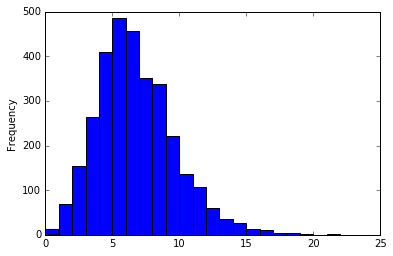

In [24]:
feats_import.loc[:, 'ChancesH'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'ChancesH'])))

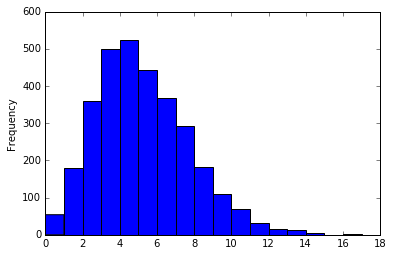

In [25]:
feats_import.loc[:, 'ChancesA'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'ChancesA'])))

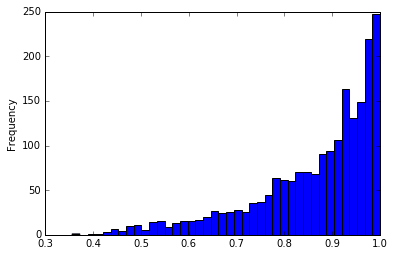

In [37]:
feats_import.loc[feats_import['Attendance']<1, 'Attendance'].plot(kind='hist', bins=40)

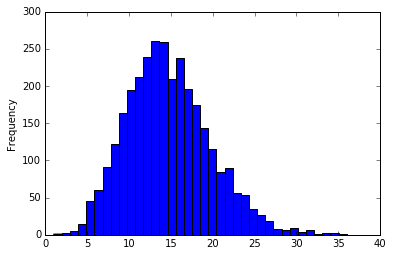

In [31]:
feats_import.loc[:, 'HS'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'HS'])))

In [16]:
# Test dropping out certain features, outdated. 

# kfold = KFold(n_splits=10, shuffle=True)

# performance_list = []
# for i in range(1,21,2):
#     if i<3:
#         continue
#     np.random.seed(7)
#     X_vary = np.delete(X,(i,i+1),1)
    
#     def baseline_model():
#         model = Sequential()
#         model.add(Dense(40, input_dim=len(X_vary[0]), init='uniform', activation='relu')) 
#         # model.add(Dropout(0.3))
#         model.add(Dense(20, activation='sigmoid'))
#         model.add(Dense(80, activation='relu'))
#         model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))

#         model.compile(optimizer='adam',
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
#         return model
#     estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=20, batch_size=20, verbose=0)
    
#     results = cross_val_score(estimator, X_vary, y, cv=kfold)
#     print feats.columns[i:i+2]
#     print [i, 100*results.mean(), 100*results.std()]
#     performance_list += [i, 100*results.mean(), 100*results.std()]


In [17]:
# Outdated

# np.random.seed(7)
# X_vary = X

# def baseline_model():
#     model = Sequential()
#     model.add(Dense(40, input_dim=len(X_vary[0]), init='lecun_uniform', activation='relu')) 
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))
#     model.add(Activation('softmax'))

#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model
# estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=100, batch_size=10, verbose=0)

# results = cross_val_score(estimator, X_vary, y)
# print 100*results.mean(), 100*results.std()

In [69]:
teams_df = pd.read_csv('Team_ID_hardcoded.csv')

In [63]:
feats.columns

Index([u'ChancesH', u'ChancesA', u'Attendance', u'FTHG', u'HTHG', u'HS', u'AS',
       u'HST', u'AST', u'HF', u'AF', u'HC', u'AC', u'HY', u'AY', u'HR', u'AR',
       u'HGA', u'AGA', u'FTGD', u'HTGD', u'Odds', u'HP3', u'AP3'],
      dtype='object')

In [206]:
# Goal differential Cut-off.
cutoff_GD = 3

feats = feats_import.drop(['Season', 'Gameday', 'TID_H', 'TID_A', 'GoalsH', 'GoalsA', "CornersH", "CornersA", "Odds"], axis=1).drop('FTGD', axis=1)
feats.loc[:, 'HTGD'] = feats_import.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1


# Different norms because I played around with different columns
norm = [22, 22, 1, 9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, GD_spread-1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, GD_spread-1, 1, 1, 1]

feats = feats/norm

season15_end = feats_import[feats_import['Season']==2016].index[0]
ID = np.eye(GD_spread)

X = feats.iloc[:season15_end].as_matrix()
y_pre = map(int, label.iloc[:season15_end].as_matrix())

y = np.array([ID[i] for i in y_pre])


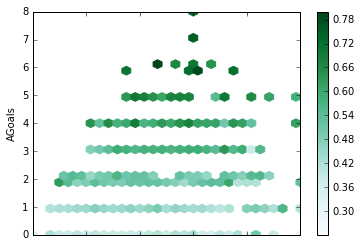

In [180]:
# Thinking about new features like conversion rate for shots etc.

conversion_df = feats_import.loc[:, ['FTGD', 'FTHG', 'HS', 'HST', 'AS', 'AST', 'HGA', 'AGA']]
conversion_df.loc[:, 'HGoals'] = conversion_df.loc[:, 'FTHG']
conversion_df.loc[:, 'AGoals'] = np.abs(conversion_df.loc[:, 'FTGD'] - conversion_df.loc[:, 'HGoals'])
conversion_df.loc[:, 'HConv'] = conversion_df.loc[:, 'HST'] / conversion_df.loc[:, 'HS']
conversion_df.loc[:, 'AConv'] = conversion_df.loc[:, 'AST'] / conversion_df.loc[:, 'AS']

conversion_df.loc[:, 'GD_color'] = (conversion_df.loc[:, 'FTGD'] - np.min(conversion_df.loc[:, 'FTGD']))

conversion_df.plot.hexbin(x='AConv', y='AGoals', C='AGA', gridsize=30)

In [181]:
# Assign an expected score with probabilities
def exp_score(x):
    multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    # multiplier = np.array([-2.5, 1, 0, 1, 2.7])
    return np.sum(np.array(x) * multiplier)

In [242]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for know.
model = Sequential()
model.add(Dense(50, input_dim=len(X[0]), init='lecun_uniform', activation='relu')) 
model.add(Dense(500, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*cutoff_GD+1, activation='relu'))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X, y, nb_epoch=100, batch_size=10, verbose=False)
print model.evaluate(X, y, batch_size=10, verbose=False)[1]

predictions = model.predict_proba(X)

0.790322578801
2880/3038 [===========================>..] - ETA: 0s

In [211]:
# Cross-Tabulation for Away-Win (-1), Draw (0) or Home-win (1)
performance_df = pd.concat([
        feats_import.iloc[:season15_end,-5].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions)), name='EXP', index=feats_import.iloc[:season15_end].index)], axis=1)
success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_res_df)/season15_end,2)) + " percent"
success_res_df


Success identifying H, D, A is 92.17 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,846,67,0
0.0,71,624,55
1.0,2,43,1330


In [212]:
# Cross-Tabulation for exact goal differential

success_df = pd.crosstab(performance_df.loc[:, "FTGD"], performance_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_df.loc[:, "EXP"].min())
exp_max = int(performance_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_df.ix[i,i] for i in range(exp_min,exp_max+1)])/season15_end,2)) + " percent"
success_df

Success identifying GD is 78.47 percent


EXP,-3.0,-2.0,-1.0,-0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,132,45,0,1,0,0,0
-2.0,21,147,103,3,0,0,0
-1.0,0,69,329,63,0,0,0
0.0,0,2,69,624,54,1,0
1.0,0,0,2,43,522,42,0
2.0,0,0,0,0,87,295,29
3.0,0,0,0,0,0,20,335


In [213]:
# Find all games that ended with an away win by one goal where the algorithm called a draw (Check invidiual games.)
# Example: Last two games all were won in last 30 minutes by away team after being behind until that point by 1 or 2 goals.
pd.merge(
    pd.merge(
        pd.merge(
            performance_df[(performance_df['FTGD'].astype(int) == -1) & (performance_df['EXP'].astype(int) == 0)],
            feats_import.loc[:, ['TID_H', 'TID_A', 'Season', 'Gameday']], how='inner', left_index=True, right_index=True),
        teams_df,
        left_on='TID_H', right_on='TID').sort_values(['Season','Gameday']),
    teams_df,
    left_on='TID_A', right_on='TID', suffixes=('_H', '_A')).sort_values(['Season','Gameday']).drop(['TID_H', 'TID_A', 'KID_H', 'KID_A'], axis=1).head()

,FTGD,EXP,Season,Gameday,TName_H,TName_A
0,-1.0,-0.0,2006.0,14.0,Hamburg,Bayern Munich
3,-1.0,-0.0,2006.0,17.0,Bielefeld,Schalke 04
10,-1.0,-0.0,2006.0,29.0,M'gladbach,Hamburg
18,-1.0,-0.0,2007.0,5.0,Duisburg,Hertha
19,-1.0,-0.0,2007.0,7.0,Nurnberg,Leverkusen


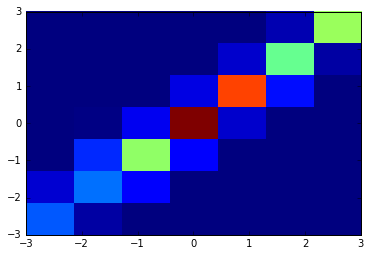

In [214]:
# Matrix Plot to visualize predictions vs. outcome

# x-axis: Actual outcome
# y-axis: Expected score (EXP)
plt_x = np.array(performance_df.loc[:, "FTGD"])
plt_y = np.array(performance_df.loc[:, "EXP"])

fig, ax = plt.subplots()

plt.hist2d(plt_x, plt_y, bins=2*cutoff_GD+1, range=np.array([(-cutoff_GD,cutoff_GD), (-cutoff_GD,cutoff_GD)]))
plt.show()

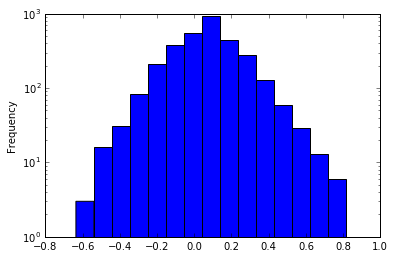

In [187]:
fig, ax = plt.subplots()
ax.set_yscale('log')
(feats.loc[:, "ChancesH"]-feats.loc[:, "ChancesA"]).plot(kind='hist', bins=15)

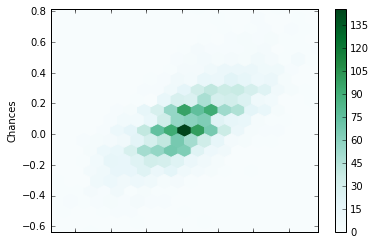

In [216]:
pd.concat([(feats.loc[:, "ChancesH"]-feats.loc[:, "ChancesA"]).rename('Chances'),
           (feats.loc[:, "HGA"]-feats.loc[:, "AGA"]).rename('G')],axis=1).plot.hexbin(y='Chances', x='G', gridsize=20)

In [217]:
# Define luck: Wherever our original algorithm was wrong.
# This needs to be refined obviously.
# Create df with only correctly predicted games and then learn on them
feats.loc[:, 'luck'] = (performance_df.loc[:, 'FTGD'] - performance_df.loc[:, 'EXP']).apply(np.abs).apply(np.sign)
feats_noluck = feats[feats['luck']==0].drop('luck', axis=1)

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1


# Different norms because I played around with different columns
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, GD_spread-1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, GD_spread-1, 1, 1, 1]

feats_noluck = feats[feats['luck']==0].drop('luck', axis=1)
label_noluck = label.to_frame().merge(feats_noluck, left_index=True, right_index=True).loc[:, 'FTGD']


# ID for index to find end of 2015/16 season
ID = np.eye(GD_spread)

X_noluck = feats_noluck.ix[:season15_end].as_matrix()
y_pre_noluck = map(int, label_noluck.ix[:season15_end].as_matrix())

y_noluck = np.array([ID[i] for i in y_pre_noluck])

In [228]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for know.
model_noluck = Sequential()
model_noluck.add(Dense(50, input_dim=len(X_noluck[0]), init='lecun_uniform', activation='relu')) 
model_noluck.add(Dense(500, activation='relu'))
model_noluck.add(Dense(50, activation='relu'))
model_noluck.add(Dropout(0.4))
model_noluck.add(Dense(2*cutoff_GD+1, activation='relu'))
model_noluck.add(Activation('softmax'))

model_noluck.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_noluck.fit(X_noluck, y_noluck, nb_epoch=100, batch_size=10, verbose=False)
print model_noluck.evaluate(X_noluck, y_noluck, batch_size=10, verbose=False)[1]

predictions_noluck = model_noluck.predict_proba(X_noluck)

0.968540262456
2048/2384 [========================>.....] - ETA: 0s

In [243]:
model == model_noluck

False

In [238]:
predictions_noluck = model_noluck.predict_proba(X_noluck)

2336/2384 [============================>.] - ETA: 0s

## EVERYTHING BELOW HERE IS NOT FULLY WORKING YET.

In [244]:
performance_noluck_df = pd.concat([
        (label_noluck.ix[:season15_end]-cutoff_GD).apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_noluck)), name='EXP', index=label_noluck.ix[:season15_end].index)], axis=1)
success_noluck_res_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"].apply(np.sign), performance_noluck_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_noluck_res_df)/len(label_noluck.ix[:season15_end]),2)) + " percent"
success_noluck_res_df



Success identifying H, D, A is 98.45 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,606,2,0
0.0,3,618,3
1.0,0,29,1123


In [230]:
success_noluck_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"], performance_noluck_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_noluck_df.loc[:, "EXP"].min())
exp_max = int(performance_noluck_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_noluck_df.ix[i,i] for i in range(exp_min,exp_max+1)])/len(performance_noluck_df),2)) + " percent"
success_noluck_df

Success identifying GD is 96.85 percent


EXP,-3.0,-2.0,-1.0,-0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,132,0,0,0,0,0,0
-2.0,7,139,1,0,0,0,0
-1.0,0,10,317,2,0,0,0
0.0,0,0,3,618,3,0,0
1.0,0,0,0,29,482,11,0
2.0,0,0,0,0,2,286,7
3.0,0,0,0,0,0,0,335


In [245]:
X_test = feats.iloc[season15_end+1:].drop('luck', axis=1).as_matrix()
y_test_pre = map(int, label.iloc[season15_end+1:].as_matrix())

y_test = np.array([ID[i] for i in y_test_pre])

predictions_new_season = model.predict_proba(X_test)
predictions_new_season_noluck = model_noluck.predict_proba(X_test)
print '\n'

# Measure performance without thinking about luck
performance_new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,-5].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_new_season)), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_res_df)/len(X_test),2)) + " percent"
success_res_df


 32/116 [=======>......................] - ETA: 0s

Success identifying H, D, A is 80.17 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,23,9,0
0.0,4,15,9
1.0,0,1,55


### How many goals are scored more for the winning on average when the GD > cutoff

In [194]:
weights = feats_import.ix[:, 'FTGD'].value_counts(False, False, True).to_frame()
weights.loc[:, 'GD'] = weights.index
bla = weights[weights['GD']>=cutoff_GD]
print bla
print np.sum(bla.loc[:, 'FTGD']*bla.loc[:, 'GD'])/np.sum(bla.loc[:, 'FTGD'])

     FTGD   GD
3.0   222  3.0
4.0    98  4.0
5.0    31  5.0
6.0     8  6.0
7.0     6  7.0
8.0     1  8.0
3.58196721311


In [248]:
new_season_noluck_df = pd.concat([
        feats_import.iloc[season15_end+1:,-5].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(exp_score, predictions_new_season_noluck), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)

new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,-5].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(exp_score, predictions_new_season), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)

In [259]:
comparison_df = pd.concat([new_season_df, new_season_noluck_df.loc[:, 'EXP'].rename('EXP w/o luck')], axis=1).apply(np.round, args=(2,))

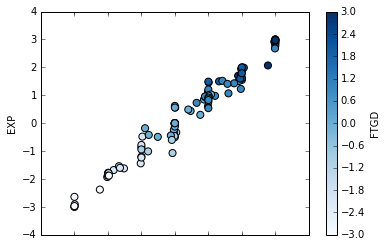

In [275]:
comparison_df.plot(kind='scatter', x='EXP w/o luck', y='EXP', c='FTGD', s=50, colormap='Blues')

In [268]:
output_df = pd.merge(new_season_noluck_df, feats_import.loc[:, ['TID_H', 'TID_A', 'Gameday']], how='inner', left_index=True, right_index=True)
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_H', right_on='TID')
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_A', right_on='TID')

output_df = output_df.drop(['TID_x', 'TID_y'], axis=1)



tid = 5
# pd.merge(output_df.query('TID_A==5'),           output_df.query('TID_H==5'))
schalke_df = pd.concat([output_df[output_df['TID_H'] == tid], output_df[output_df['TID_A'] == tid]], axis=0).drop(['TID_H', 'TID_A'], axis=1).sort_values(by='Gameday')
schalke_df = schalke_df.loc[:, ['Gameday', 'TName_x', 'TName_y', 'FTGD', 'EXP']].set_index('Gameday')
schalke_df.columns = ['Home_Team', 'Away_Team', 'Final', 'Expected']
schalke_df.loc[:, 'Expected'] = schalke_df.loc[:, 'Expected'].apply(np.round, args=(4,)) 
schalke_df

,Home_Team,Away_Team,Final,Expected
Gameday,,,,
1.0,Ein Frankfurt,Schalke 04,1.0,0.9994
2.0,Schalke 04,Bayern Munich,-2.0,-0.0054
3.0,Hertha,Schalke 04,2.0,1.9986
4.0,Schalke 04,FC Koln,-2.0,-1.0157
5.0,Hoffenheim,Schalke 04,1.0,0.9933
6.0,Schalke 04,M'gladbach,3.0,3.0000
7.0,Augsburg,Schalke 04,0.0,0.3982
8.0,Schalke 04,Mainz,3.0,3.0000
9.0,Dortmund,Schalke 04,0.0,-0.0339


In [274]:
output_df = pd.merge(new_season_noluck_df, feats_import.loc[:, ['TID_H', 'TID_A', 'Gameday']], how='inner', left_index=True, right_index=True)
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_H', right_on='TID')
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_A', right_on='TID')

output_df = output_df.drop(['TID_x', 'TID_y'], axis=1)



tid = 2
# pd.merge(output_df.query('TID_A==5'),           output_df.query('TID_H==5'))
schalke_df = pd.concat([output_df[output_df['TID_H'] == tid], output_df[output_df['TID_A'] == tid]], axis=0).drop(['TID_H', 'TID_A'], axis=1).sort_values(by='Gameday')
schalke_df = schalke_df.loc[:, ['Gameday', 'TName_x', 'TName_y', 'FTGD', 'EXP']].set_index('Gameday')
schalke_df.columns = ['Home_Team', 'Away_Team', 'Final', 'Expected']
schalke_df.loc[:, 'Expected'] = schalke_df.loc[:, 'Expected'].apply(np.round, args=(4,)) 
schalke_df

,Home_Team,Away_Team,Final,Expected
Gameday,,,,
1.0,M'gladbach,Leverkusen,1.0,0.9874
2.0,Leverkusen,Hamburg,2.0,2.0616
3.0,Ein Frankfurt,Leverkusen,1.0,1.9121
4.0,Leverkusen,Augsburg,0.0,-0.0000
5.0,Mainz,Leverkusen,-1.0,-0.0265
6.0,Leverkusen,Dortmund,2.0,1.9817
7.0,Werder Bremen,Leverkusen,1.0,0.9993
8.0,Leverkusen,Hoffenheim,-3.0,-3.0000
9.0,Wolfsburg,Leverkusen,-1.0,-0.0041


,Season,Gameday,Link,Score,Minute,Player
0,2006.0,1.0,0.0,-1.0,37.0,30176.0
1,2006.0,1.0,0.0,-2.0,45.0,144.0
2,2006.0,1.0,0.0,-3.0,78.0,27610.0
3,2006.0,1.0,1.0,-1.0,32.0,29515.0
4,2006.0,1.0,1.0,0.0,67.0,37363.0
5,2006.0,1.0,2.0,1.0,24.0,25031.0
6,2006.0,1.0,2.0,2.0,55.0,27701.0
7,2006.0,1.0,3.0,1.0,51.0,27510.0
8,2006.0,1.0,3.0,2.0,60.0,9039.0
9,2006.0,1.0,4.0,1.0,30.0,26143.0
